In [1]:
import pandas as pd
import numpy as np
import sklearn
from pathlib import Path


In [ ]:
import torch
print(f"PyTorch: {torch.__version__}")
print(f"CUDA 사용 가능: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA: {torch.version.cuda}")

PyTorch: 2.10.0+cu128
CUDA 사용 가능: True
GPU: NVIDIA GeForce RTX 4060 Laptop GPU


In [3]:
print(f"numpy: {np.__version__}")
print(f"pandas: {pd.__version__}")
print(f"scikit-learn: {sklearn.__version__}")
print(f"torch: {torch.__version__}")

numpy: 2.4.2
pandas: 3.0.0
scikit-learn: 1.8.0
torch: 2.10.0+cu128


1. 데이터 불러오기
2. 데이터 전처리
3. 데이터 분할
4. 데이터 정규화
---
5. 학습/검증/테스트 데이터(텐서로 변경해야 함)
6. 모델 생성
7. 학습
8. 예측
9. 평가

0. 데이터 크기 설정
1. 데이터 불러오기
2. 전처리 (IQR, Savgol)
3. Sliding Windows 생성
4. Train/Val/Test Split 
5. scaler.fit(Train만)  # ← 핵심!
6. Train: scaler.transform(Train)
7. Val: scaler.transform(Val)
8. Test: scaler.transform(Test)

0. 데이터 크기 설정

In [4]:
input_time = 144
output_time = 10
min_required = input_time + output_time

print(f"=== 설정 ===")
print(f"입력: {input_time}분 ({input_time/60:.1f}시간)")
print(f"출력: {output_time}분")
print(f"최소 필요: {min_required}분")

=== 설정 ===
입력: 144분 (2.4시간)
출력: 10분
최소 필요: 154분


1. 데이터 불러오기
- J배수지 "csv.10 " 사용
- load 후 저장

In [5]:
BASE_DIR = Path.cwd().parent

In [6]:
BASE_DIR

PosixPath('/home/kp/work/pro')

In [7]:
csv_file = BASE_DIR / "data" / "rawdata" / "reservoir"

In [8]:
df = pd.read_csv(
    csv_file/"10.csv", 
    header=None, 
    usecols=[1, 2], 
    names=['time', 'value'],
    parse_dates=['time']
).sort_values('time').reset_index(drop=True)

df['time'] = pd.to_datetime(df['time'])

# 1년 필터링 (2023년) - DatetimeIndex로 변환하여 Pylance 타입 에러 방지
df = df[pd.DatetimeIndex(df['time']).year == 2023].reset_index(drop=True)

# 테스트용 600개만 사용
df = df.head(600)

print(f"\n=== 데이터 확인 ====")
print(f"데이터: {len(df)}개 (테스트용 600개)")
print(f"기간: {df['time'].min()} ~ {df['time'].max()}")


=== 데이터 확인 ====
데이터: 600개 (테스트용 600개)
기간: 2023-01-01 00:01:00 ~ 2023-01-01 10:00:00


2. 데이터 전처리
- IQR
- 결측치 보간 (interpolate)
- Savgol filter 적용

In [9]:
import pandas as pd

df_filtered = df.copy()

# 1. IQR 이상치 제거
Q1 = df_filtered["value"].quantile(0.25)
Q3 = df_filtered["value"].quantile(0.75)

IQR = Q3 - Q1

upper = Q3 + 1.5 * IQR
lower = Q1 - 1.5 * IQR
iqr_mask = (df_filtered['value'] < lower) | (df_filtered['value'] > upper)

# 2. 음수 값 (센서 오류)
negative_mask = df_filtered['value'] < 0

# 급격한 변동 (상위 0.1%)
diff = df_filtered['value'].diff().abs()
spike_threshold = diff.quantile(0.999)
spike_mask = diff > spike_threshold

# 한 번에 제거
total_mask = iqr_mask | negative_mask | spike_mask
df_filtered.loc[total_mask, 'value'] = np.nan

print(f"제거 내역:")
print(f"  IQR: {iqr_mask.sum()}개")
print(f"  음수: {negative_mask.sum()}개")
print(f"  급변동 (>{spike_threshold:.2f}): {spike_mask.sum()}개")
print(f"  총 제거: {total_mask.sum()}개 (중복 제외)")

# 보간 1회만 수행
df_filtered['value'] = df_filtered['value'].interpolate(method='linear', limit_direction='both')

# 보간으로 생성 된 음수 방지
df_filtered['value'] = df_filtered['value'].clip(lower=0)

print(f"\n처리 후 범위: [{df_filtered['value'].min():.2f}, {df_filtered['value'].max():.2f}]")
print(f"음수 값: {(df_filtered['value'] < 0).sum()}개")
print(f"1분 변동량 최대: {df_filtered['value'].diff().abs().max():.2f}")
print(f"IQR 후: {len(df_filtered)}개")

제거 내역:
  IQR: 104개
  음수: 0개
  급변동 (>73.22): 1개
  총 제거: 105개 (중복 제외)

처리 후 범위: [67.42, 144.76]
음수 값: 0개
1분 변동량 최대: 26.34
IQR 후: 600개


savgol_filter 적용

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
from scipy.signal import savgol_filter

# 백업
df_before_savgol = df_filtered.copy()

# Savgol 필터
window_length = 51  # 홀수여야 함
polyorder = 2

df_filtered['value'] = savgol_filter(
    df_filtered['value'], 
    window_length=window_length,
    polyorder=polyorder
)

print(f"Savgol 적용 (window={window_length})")

Savgol 적용 (window=51)


[이상치 제거 확인용]

In [11]:
fig, axes = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

# 1. 시계열 비교
axes[0].plot(df_before_savgol['value'], 
            label='Before Savgol (IQR Only)', alpha=0.6, linewidth=1.5, color='blue')
axes[0].plot(df_filtered['value'], 
            label='After Savgol (IQR + Savgol)', linewidth=2, color='green')
axes[0].set_ylabel('Value', fontsize=12)
axes[0].set_title('Before vs After Savgol Filter', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# 2. 변화율 비교
diff_before = np.diff(df_before_savgol['value'])
diff_after = np.diff(df_filtered['value'])

axes[1].plot(diff_before, label='Before Savgol', alpha=0.6, linewidth=1, color='blue')
axes[1].plot(diff_after, label='After Savgol', linewidth=1.5, color='green')
axes[1].axhline(0, color='black', linestyle='-', linewidth=0.5)
axes[1].set_xlabel('Time (Minutes)', fontsize=12)
axes[1].set_ylabel('Change (Δ)', fontsize=12)
axes[1].set_title('1-Minute Rate of Change', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('result.png')
plt.close()
# ========== 통계 ==========
print("\n" + "="*60)
print("Savgol 적용 효과")
print("="*60)
print(f"Before:")
print(f"  평균 변화: {np.mean(np.abs(diff_before)):.4f}")
print(f"  최대 변화: {np.max(np.abs(diff_before)):.4f}")
print(f"  표준편차: {np.std(diff_before):.4f}")

print(f"\nAfter:")
print(f"  평균 변화: {np.mean(np.abs(diff_after)):.4f}")
print(f"  최대 변화: {np.max(np.abs(diff_after)):.4f}")
print(f"  표준편차: {np.std(diff_after):.4f}")

reduction = (1 - np.std(diff_after) / np.std(diff_before)) * 100
print(f"\n변동성 감소: {reduction:.2f}%")
print("="*60)

# 백업 삭제
del df_before_savgol


Savgol 적용 효과
Before:
  평균 변화: 2.4505
  최대 변화: 26.3418
  표준편차: 4.0282

After:
  평균 변화: 0.5885
  최대 변화: 3.8102
  표준편차: 0.9436

변동성 감소: 76.57%


통계 요약

In [12]:
print("\n" + "="*60)
print("데이터 전처리 통계 요약 (IQR 1회만 적용)")
print("="*60)

print(f"\n원본 데이터:")
print(f"  개수: {len(df):,}")
print(f"  범위: [{df['value'].min():.2f}, {df['value'].max():.2f}]")
print(f"  평균: {df['value'].mean():.2f} ± {df['value'].std():.2f}")

print(f"\nIQR 후 (최종):")
print(f"  개수: {len(df_filtered):,}")
print(f"  제거: {len(df) - len(df_filtered):,}개 ({(len(df)-len(df_filtered))/len(df)*100:.2f}%)")
print(f"  범위: [{df_filtered['value'].min():.2f}, {df_filtered['value'].max():.2f}]")
print(f"  평균: {df_filtered['value'].mean():.2f} ± {df_filtered['value'].std():.2f}")

print("="*60)


데이터 전처리 통계 요약 (IQR 1회만 적용)

원본 데이터:
  개수: 600
  범위: [56.29, 196.04]
  평균: 109.58 ± 25.58

IQR 후 (최종):
  개수: 600
  제거: 0개 (0.00%)
  범위: [63.84, 132.14]
  평균: 107.59 ± 14.98


3. Slding Windows 생성
슬라이딩 윈도우를 사용하여 dataset

X[i : i+60] : 과거 60분간의 연속된 데이터 (예: 00:00 ~ 00:59).
y[i+60 : (i+60)+10] : 이후 10분간의 예측 목표 데이터 (예: 01:00 ~ 01:09).

time = index
value = idx[n]

In [13]:
print(f"\n=== 슬라이딩 윈도우 생성 ===")


=== 슬라이딩 윈도우 생성 ===


- ascontiguousarray 동작. 불연속 -> 연속
sliding_window_view의 view를 실제 복사로 전환
새 메모리: [0,1,2, 1,2,3, 2,3,4, 3,4,5]
            ─────  ─────  ─────  ─────
            X[0]   X[1]   X[2]   X[3]

In [14]:
def create_sliding_windows(data, input_time, output_time):

    """ 
    슬라이딩 윈도우 생성 (y는 2D로)

    Ags:
        data: 1D numpy array
        input_time : 윈도우 크기 
        output_time: 출력 윈도우 크기

    Returns:
        X: (n_samples, input_time, 1) - 3D
        y: (n_samples, output_time) - 2D
    """
    
    X, y = [], []
    n=len(data)
    n_samples = n - input_time - output_time + 1

    # 메모리 복사 없이 **view**만 생성 (stride 조작). 실제복사 X. 포인터만 참조
    X = np.lib.stride_tricks.sliding_window_view(data, input_time)[:n_samples]

    # 핵심: **`data[input_time:]`** → X의 각 윈도우가 끝난 **직후** 시점부터 시작
    y = np.lib.stride_tricks.sliding_window_view(data[input_time:], output_time)[:n_samples]

    # `ascontiguousarray`: stride_tricks가 만든 view는 메모리가 불연속적일 수 있어서 연속 배열로 복사
    X = np.ascontiguousarray(X).reshape(-1, input_time, 1)
    y = np.ascontiguousarray(y)

    return X, y


# 정규화 전에 슬라이딩 윈도우 생성
value_numpy = df_filtered['value'].values # tablel에서 value 값만 get.

X, y = create_sliding_windows(value_numpy, input_time, output_time)

# LSTM에 사용하기 위해 뒤에 1차원 추가
# X_reshape=X.reshape(X.shape[0], X.shape[1], 1)
# y_reshpae=y.reshape(y.shape[0], y.shape[1], 1)

# X_reshape = X[:, :, np.newaxis]
# y_reshape = y[:, :, np.newaxis]

print(f"\nX shape: {X.shape}")
print(f"y shape: {y.shape}")

if len(X) == 0:
    raise ValueError("슬라이딩 윈도우 생성 실패!")


X shape: (447, 144, 1)
y shape: (447, 10)


4. 데이터 분할
- Train, Validation, Test Split (0.7/0.15/0.15)

In [15]:
print(f"\n=== Train/Validation/Test Split ===")


=== Train/Validation/Test Split ===


In [16]:
import torch

n_samples = len(X)
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

train_idx = int(n_samples * train_ratio)
val_idx = int(n_samples * (train_ratio + val_ratio))

X_train = X[:train_idx]
y_train = y[:train_idx]

X_val = X[train_idx:val_idx]
y_val = y[train_idx:val_idx]

X_test = X[val_idx:]
y_test = y[val_idx:]

print(f"Train: {X_train.shape[0]}개 ({train_ratio*100:.0f}%)")
print(f"Validation: {X_val.shape[0]}개 ({val_ratio*100:.0f}%)")
print(f"Test: {X_test.shape[0]}개 ({test_ratio*100:.0f}%)")

Train: 312개 (70%)
Validation: 67개 (15%)
Test: 68개 (15%)


샘플 50,000개로 실행

In [17]:
# max_samples = 50000
# step = len(X_train) // max_samples

# X_train = X_train[::step][:max_samples]
# y_train = y_train[::step][:max_samples]

# print(f"테스트용 Train 샘플: {len(X_train)}개")

5. MinMaxScaler 데이터 정규화 (Train으로만 Fit)

In [18]:
print(f"\n=== 정규화 (Train 기준) ===")


=== 정규화 (Train 기준) ===


In [19]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Train 데이터로만 Scaler Fit
scaler = MinMaxScaler()
scaler.fit(X_train.reshape(-1,1))

# min/max 추출 -> reshape 없이 직접 연산
data_min = scaler.data_min_[0]
data_max = scaler.data_max_[0]

def normalize(arr): # 정규화
    return (arr - data_min) / (data_max - data_min)

def denormalize(arr): # 역변환
    return arr * (data_max - data_min) + data_min

# 1. reshape(-1, 1) ->2D배열  / 2. X_ .shape 으로 변경
# 각 세트 Transform
X_train_scaled = normalize(X_train)
X_val_scaled = normalize(X_val)
X_test_scaled = normalize(X_test)

# y도 같은 Scaler로 Transform
y_train_scaled = normalize(y_train)
y_val_scaled = normalize(y_val)
y_test_scaled = normalize(y_test)

print(f"✅ Train 데이터로만 Fit 완료")
print(f"Scaler 범위: [{data_min:.2f}, {data_max:.2f}]")

✅ Train 데이터로만 Fit 완료
Scaler 범위: [63.84, 131.73]


In [20]:
# value_numpy = value_numpy[:600]

- Tensor 변환

In [21]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nDevice: {device}")

# 텐서 변환
X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
y_train_tensor = torch.FloatTensor(y_train_scaled).to(device)

X_val_tensor = torch.FloatTensor(X_val_scaled).to(device)
y_val_tensor = torch.FloatTensor(y_val_scaled).to(device)

X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
y_test_tensor = torch.FloatTensor(y_test_scaled).to(device)


Device: cuda


- DataLoader

In [22]:
from torch.utils.data import DataLoader, TensorDataset

batch_size=32  # 소량 데이터용

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=0,
    pin_memory=False,
    drop_last=False, 
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=64,
    shuffle=False,
    num_workers=0,
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=64, 
    shuffle=False,
    num_workers=0,
)

print(f"\n=== DataLoader ===")
print(f"Batch size: {batch_size}")
print(f"Train batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")


=== DataLoader ===
Batch size: 32
Train batches: 10
Validation batches: 2
Test batches: 2


6. LSTM 

In [23]:
import torch
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=1, output_size=10, dropout=0.2):
        super(LSTMModel, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0  # 1 layer에서는 dropout 불필요
        )

        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        """ 
        Args:
            x: (batch, 144, 1) - 144분 입력 데이터
        Returns:
            (batch, 10) - 10분 예측값
        """
        _, (hidden_cell, _) = self.lstm(x)
        last_hidden = hidden_cell[-1]  # (batch, 128)
        out = self.fc(last_hidden)     # (batch, 10)
        return out
    
model = LSTMModel(
    input_size=1,
    hidden_size=128,
    num_layers=1,
    output_size=output_time,
    dropout=0
).to(device)

total_params = sum(p.numel() for p in model.parameters())
print(f"\n=== 모델 ===")
print(f"총 파라미터: {total_params:,}개")


=== 모델 ===
총 파라미터: 68,362개


6. 학습

학습 함수 필수 사항
1. Loss Function: criterion = nn.MSELoss()
2. Optimizer: optimizer = optim.Adam(model.parameters(), lr=0.001)
3. Train Loop:
   - model.train()
   - forward → loss → backward → step
4. Eval Loop:
   - model.eval()
   - with torch.no_grad()
5. 손실 기록: train_losses, test_losses

선택 사항
- DataLoader (배치 처리)
- Learning Rate Scheduler (학습률 조정)
- Early Stopping (과적합 방지)
- Gradient Clipping (gradient 폭발 방지)

7. Early Stopping 클래스

In [24]:
class EarlyStopping:
    def __init__(self, patience=7, min_delta=1e-5, verbose=True): #일정 크기 개선되어야 '개선'으로 인정
        """
        Args:
        patience: validataion loss가 개선되지 않아도 기다릴 epoch 수
        min_delta: 개선으로 인정할 최소 변화량
        verbose: 로그 출력 여부
        """     
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_loss: float | None = None
        self.early_stop = False
        self.best_model: dict[str, torch.Tensor] | None = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)

        elif val_loss < self.best_loss - self.min_delta: # 의미 있는 개선으로 인정
            self.best_loss = val_loss
            self.save_checkpoint(model)
            self.counter = 0
        
        else:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter}/{self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True

    def save_checkpoint(self, model):
        ''' validation loss가 감소하면 모델 저장'''
        if self.verbose:
            print(f'Validation loss decreased ({self.best_loss:.6f}). Saving model...')
        self.best_model = model.state_dict().copy()

8. 학습
8-1. 학습 설정

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim

num_epochs = 100
learning_rate = 0.001
patience = 10

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
early_stopping = EarlyStopping(patience=patience, verbose=True)

train_losses=[]
val_losses=[]

print(f"\n=== 학습 설정 ===")
print(f"Max Epochs: {num_epochs}")
print(f"Early Stopping Patience: {patience}")
print(f"Learning Rate: {learning_rate}")


=== 학습 설정 ===
Max Epochs: 100
Early Stopping Patience: 10
Learning Rate: 0.001


8-2. 학습 루프

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
import time

print("\n" + "="*60)
print("Training Started(with Early Stopping)")
print("="*60 + "\n")

for epoch in range(num_epochs):
    epoch_start = time.time()
    # ======= Training =======
    model.train()
    train_loss_epoch = 0.0

    for batch_X, batch_y in train_loader:
        
        # Forward
        outputs = model(batch_X) # (batch, 10)
        loss = criterion(outputs, batch_y) 

        # Backward
        optimizer.zero_grad() # 기울기 초기화
        loss.backward() # 손실함수의 각 파라미터에 대한 미분값 게산
        optimizer.step() # 계산된gradient를 사용하여 실제 파라미터 값 업데이트

        train_loss_epoch += loss.item()

    avg_train_loss = train_loss_epoch / len(train_loader)
    train_losses.append(avg_train_loss)

    # ====== validation ======
    model.eval()
    val_loss_epoch = 0.0

    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss_epoch += loss.item()

    avg_val_loss = val_loss_epoch / len(val_loader)
    val_losses.append(avg_val_loss)

    epoch_time = time.time() - epoch_start

    # 출력
    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1:3d}/{num_epochs}] '
              f'Train: {avg_train_loss:.6f} '
              f'Val: {avg_val_loss:.6f} '
              f'Time: {epoch_time:.1f}s')
    
    # ===== Early Stopping Check ========
    early_stopping(avg_val_loss, model)

    if early_stopping.early_stop:
        print(f"\n⭐ Early Stopping at Epoch {epoch+1}")
        print(f"Best Validation Loss: {early_stopping.best_loss:.6f}")
        break

# Best 모델 로드
if early_stopping.best_model is not None:
    model.load_state_dict(early_stopping.best_model)

print("\n" + "="*60)
print("Training Completed")
print("="*60)


Training Started(with Early Stopping)

Validation loss decreased (0.361941). Saving model...
Validation loss decreased (0.066436). Saving model...
Validation loss decreased (0.006842). Saving model...
EarlyStopping counter: 1/10
Epoch [  5/100] Train: 0.041345 Val: 0.009845 Time: 0.0s
EarlyStopping counter: 2/10
EarlyStopping counter: 3/10
EarlyStopping counter: 4/10
EarlyStopping counter: 5/10
Validation loss decreased (0.004922). Saving model...
Epoch [ 10/100] Train: 0.026481 Val: 0.004892 Time: 0.0s
Validation loss decreased (0.004892). Saving model...
Validation loss decreased (0.003000). Saving model...
EarlyStopping counter: 1/10
EarlyStopping counter: 2/10
Validation loss decreased (0.002034). Saving model...
Epoch [ 15/100] Train: 0.010221 Val: 0.000603 Time: 0.0s
Validation loss decreased (0.000603). Saving model...
EarlyStopping counter: 1/10
EarlyStopping counter: 2/10
EarlyStopping counter: 3/10
EarlyStopping counter: 4/10
Epoch [ 20/100] Train: 0.006527 Val: 0.000828 Tim

9. Test 평가

In [27]:
print(f"\n=== Test Evaluation ===")


=== Test Evaluation ===


In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

model.eval()
test_loss_epoch = 0.0

with torch.no_grad():
    test_predictions = []
    test_actuals = []

    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        test_loss_epoch += loss.item()

        test_predictions.append(outputs.cpu().numpy())
        test_actuals.append(batch_y.cpu().numpy())

avg_test_loss = test_loss_epoch / len(test_loader)
test_predictions = np.vstack(test_predictions)
test_actuals = np.vstack(test_actuals)

# 역 정규화 (denormalize 함수 사용)
test_pred_original = denormalize(test_predictions)
test_actual_original = denormalize(test_actuals)

# 평가 지표 (원본 스케일)
test_rmse = np.sqrt(mean_squared_error(test_actual_original, test_pred_original))
test_mae = mean_absolute_error(test_actual_original, test_pred_original)

print(f"Test Loss (Normalized): {avg_test_loss:.6f}")
print(f"Test RMSE (Original Scale): {test_rmse:.4f}")
print(f"Test MAE (Original Scale): {test_mae:.4f}")

# MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

test_mape = mean_absolute_percentage_error(test_actual_original.flatten(), 
                                            test_pred_original.flatten())
print(f"Test MAPE: {test_mape:.2f}%")

Test Loss (Normalized): 0.018954
Test RMSE (Original Scale): 8.9581
Test MAE (Original Scale): 8.0344
Test MAPE: 6.41%


- 학습 결과 시각화

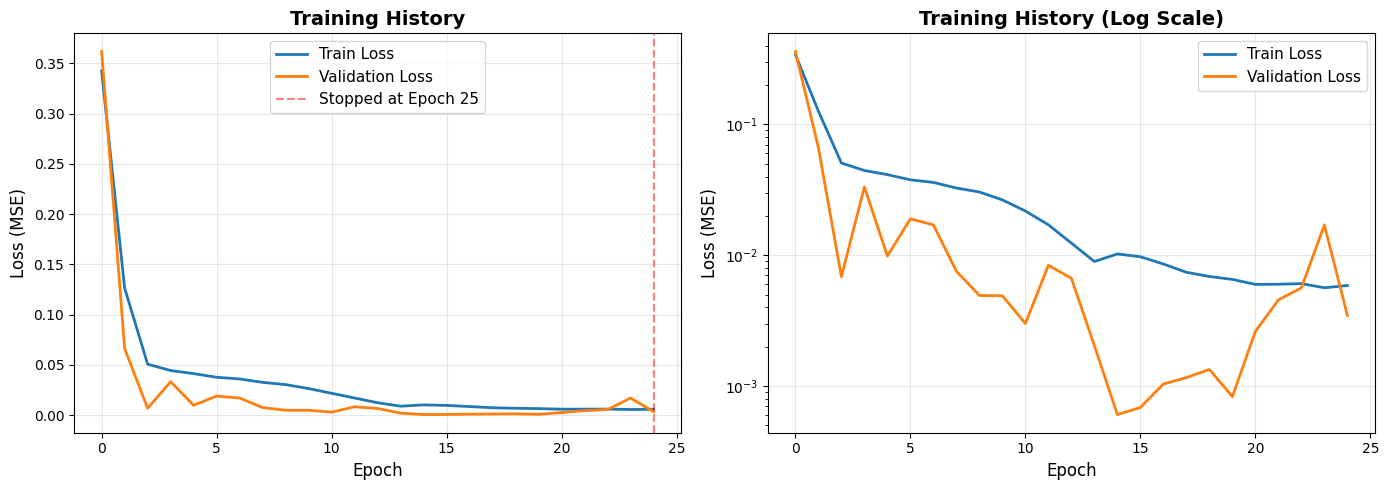

In [29]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', linewidth=2)
plt.plot(val_losses, label='Validation Loss', linewidth=2)
plt.axvline(len(train_losses)-1, color='red', linestyle='--', alpha=0.5, 
           label=f'Stopped at Epoch {len(train_losses)}')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Training History', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss', linewidth=2)
plt.plot(val_losses, label='Validation Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Training History (Log Scale)', fontsize=14, fontweight='bold')
plt.yscale('log')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

- 예측 시각화

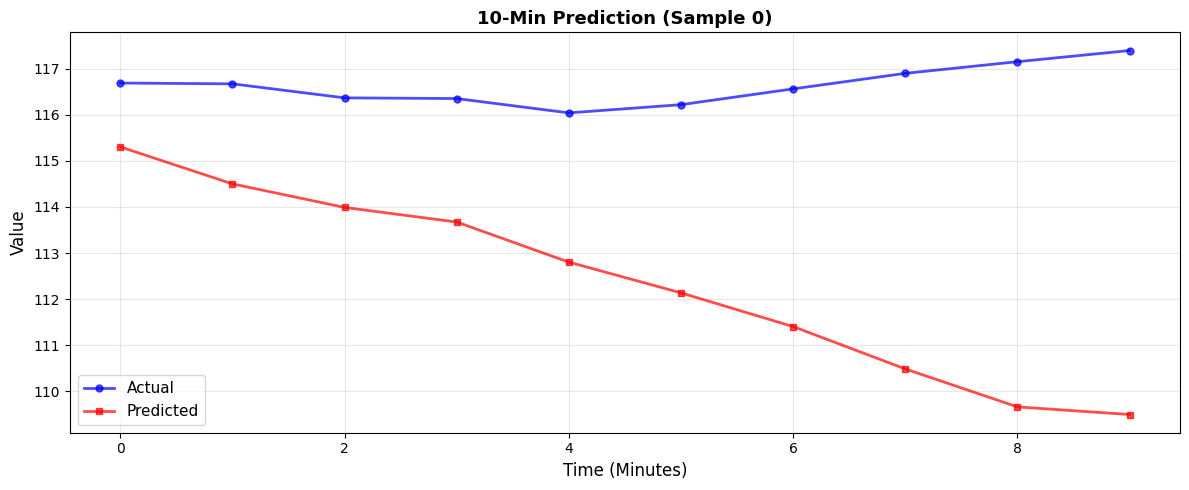

In [30]:
sample_idx = 0
actual = test_actual_original[sample_idx]
predicted = test_pred_original[sample_idx]
minutes = np.arange(output_time)  # 분 단위

plt.figure(figsize=(12, 5))
plt.plot(minutes, actual, label='Actual', 
         linewidth=2, marker='o', markersize=5, alpha=0.7, color='blue')
plt.plot(minutes, predicted, label='Predicted', 
         linewidth=2, marker='s', markersize=5, alpha=0.7, color='red')
plt.xlabel('Time (Minutes)', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.title(f'10-Min Prediction (Sample {sample_idx})', 
          fontsize=13, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

- 최종 요약

In [31]:
print("\n" + "="*60)
print("Final Summary")
print("="*60)
print(f"Data Split: Train {train_ratio*100:.0f}% / Val {val_ratio*100:.0f}% / Test {test_ratio*100:.0f}%")
print(f"Stopped at Epoch: {len(train_losses)}")
print(f"Best Val Loss: {early_stopping.best_loss:.6f}")
print(f"Test Loss: {avg_test_loss:.6f}")
print(f"Test RMSE (Original): {test_rmse:.4f}")
print(f"Test MAE (Original): {test_mae:.4f}")
print(f"Test MAPE: {test_mape:.2f}%")
print(f"Mean Error (Bias): {np.mean(test_actual_original - test_pred_original):.4f}")
print("="*60)


Final Summary
Data Split: Train 70% / Val 15% / Test 15%
Stopped at Epoch: 25
Best Val Loss: 0.000603
Test Loss: 0.018954
Test RMSE (Original): 8.9581
Test MAE (Original): 8.0344
Test MAPE: 6.41%
Mean Error (Bias): 8.0344


- 모델 저장

In [ ]:
model_path = BASE_DIR / "models" / "lstm_flow_600.pth"

torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'data_min': data_min,
    'data_max': data_max,
    'train_losses': train_losses,
    'val_losses': val_losses,
    'test_loss': avg_test_loss,
    'best_epoch': len(train_losses),
    'input_time': input_time,
    'output_time': output_time,
}, model_path)

print(f"\n모델 저장 완료: {model_path}")

/tmp/ipykernel_22086/567431069.py:18: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/kp/work/314env/lib/python3.14/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


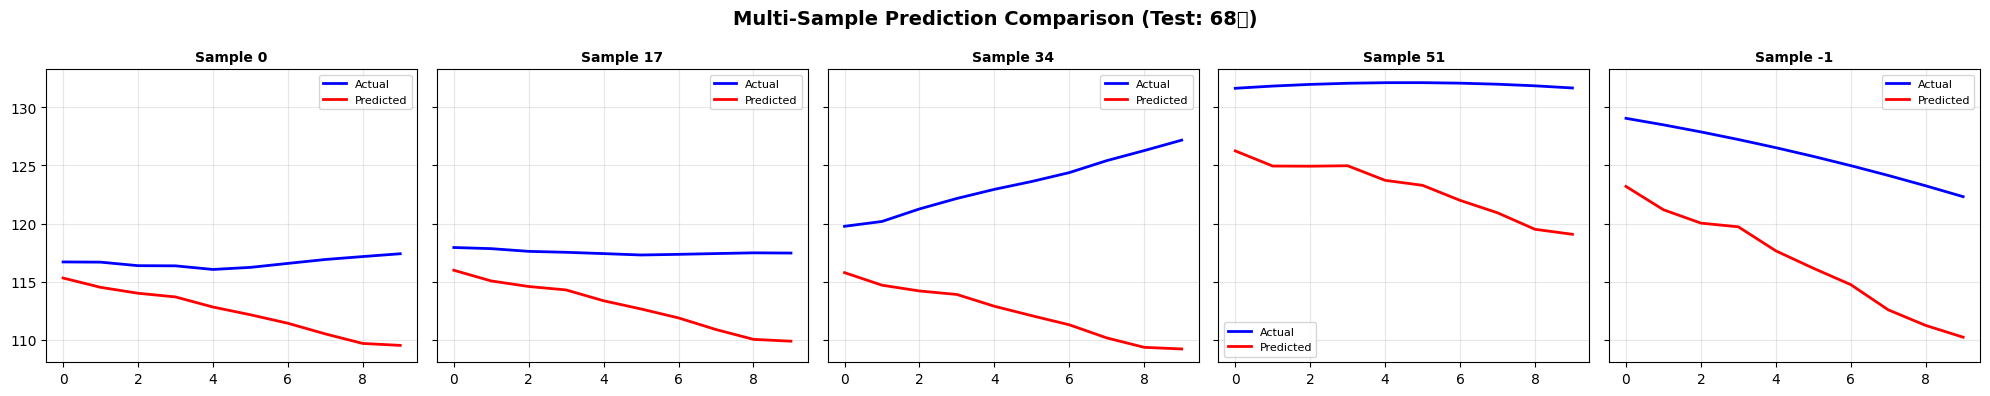

In [33]:
n_test = len(test_actual_original)
sample_indices = [0, n_test//4, n_test//2, 3*n_test//4, -1]

fig, axes = plt.subplots(1, len(sample_indices), figsize=(4*len(sample_indices), 4), sharey=True)

for idx, ax in zip(sample_indices, axes.flatten()):
    actual = test_actual_original[idx]
    predicted = test_pred_original[idx]
    minutes = np.arange(output_time)
    
    ax.plot(minutes, actual, label='Actual', linewidth=2, color='blue')
    ax.plot(minutes, predicted, label='Predicted', linewidth=2, color='red')
    ax.set_title(f'Sample {idx}', fontsize=10, fontweight='bold')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.suptitle(f'Multi-Sample Prediction Comparison (Test: {n_test}개)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

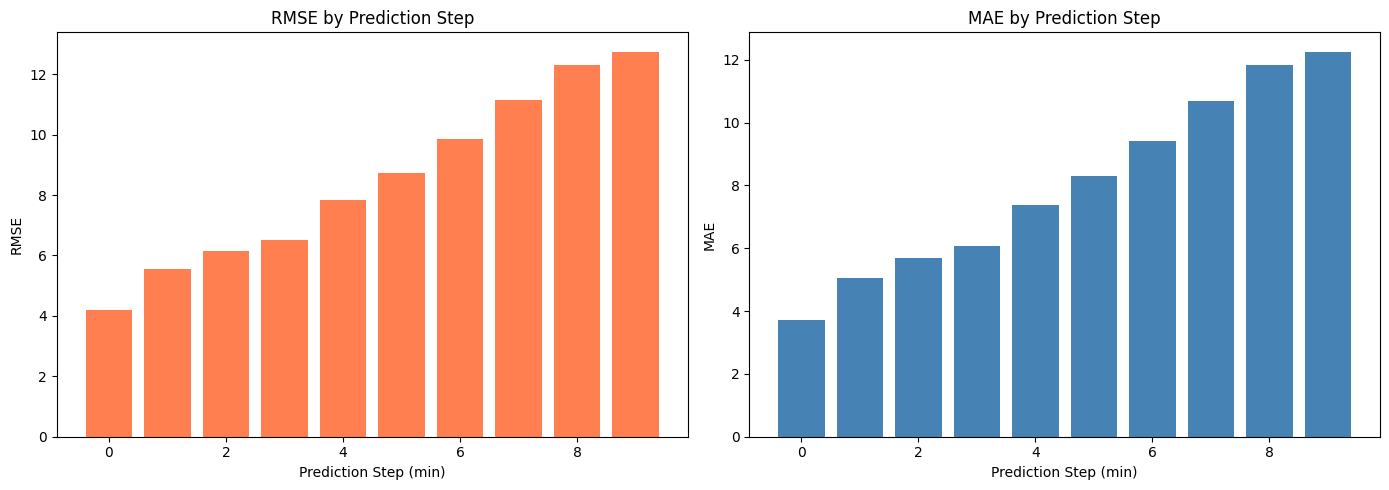

In [34]:
errors = test_actual_original - test_pred_original  # (n_samples, output_time)

step_rmse = np.sqrt(np.mean(errors**2, axis=0))
step_mae = np.mean(np.abs(errors), axis=0)

minutes = np.arange(output_time)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(minutes, step_rmse, color='coral')
axes[0].set_xlabel('Prediction Step (min)')
axes[0].set_ylabel('RMSE')
axes[0].set_title('RMSE by Prediction Step')

axes[1].bar(minutes, step_mae, color='steelblue')
axes[1].set_xlabel('Prediction Step (min)')
axes[1].set_ylabel('MAE')
axes[1].set_title('MAE by Prediction Step')

plt.tight_layout()
plt.show()

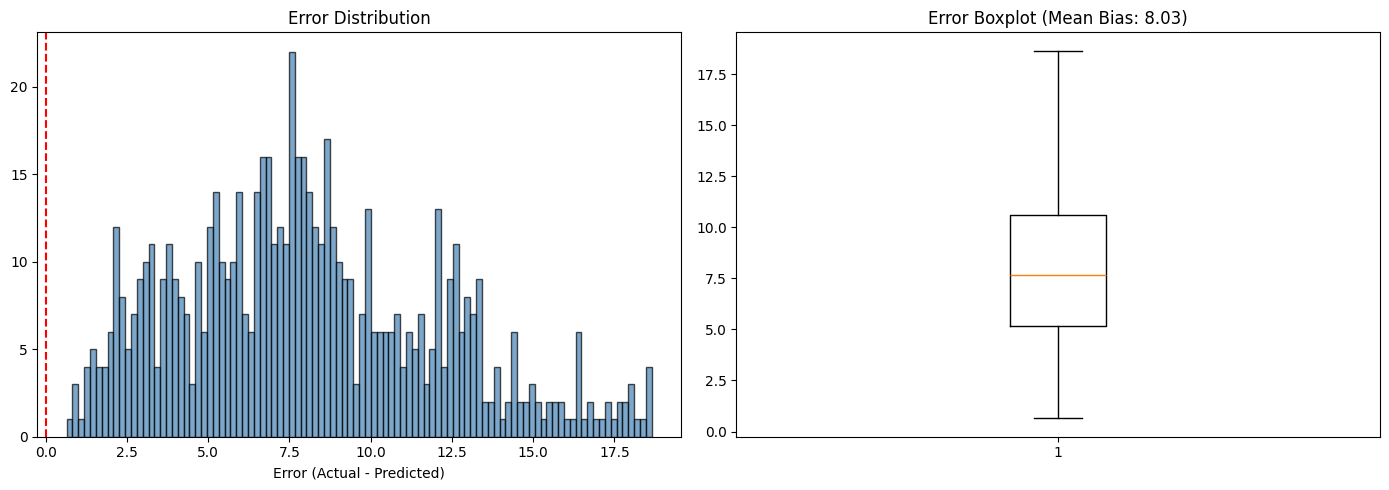

Mean Error (Bias): 8.0344
Std Error: 3.9619


In [35]:
all_errors = (test_actual_original - test_pred_original).flatten()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(all_errors, bins=100, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].axvline(0, color='red', linestyle='--')
axes[0].set_xlabel('Error (Actual - Predicted)')
axes[0].set_title('Error Distribution')

# 편향 확인
mean_error = np.mean(all_errors)
axes[1].boxplot(all_errors)
axes[1].set_title(f'Error Boxplot (Mean Bias: {mean_error:.2f})')

plt.tight_layout()
plt.show()

print(f"Mean Error (Bias): {mean_error:.4f}")
print(f"Std Error: {np.std(all_errors):.4f}")

In [36]:
# 실제값 크기별 MAPE
actuals_flat = test_actual_original.flatten()
preds_flat = test_pred_original.flatten()

bins = np.percentile(actuals_flat, [0, 25, 50, 75, 100])
labels = ['Q1(Low)', 'Q2', 'Q3', 'Q4(High)']

for i in range(len(bins)-1):
    mask = (actuals_flat >= bins[i]) & (actuals_flat < bins[i+1])
    if mask.sum() > 0:
        segment_mape = np.mean(np.abs((actuals_flat[mask] - preds_flat[mask]) / actuals_flat[mask])) * 100
        segment_rmse = np.sqrt(np.mean((actuals_flat[mask] - preds_flat[mask])**2))
        print(f"{labels[i]}: MAPE={segment_mape:.2f}%, RMSE={segment_rmse:.2f}")

Q1(Low): MAPE=3.69%, RMSE=4.84
Q2: MAPE=5.46%, RMSE=7.00
Q3: MAPE=8.90%, RMSE=11.77
Q4(High): MAPE=7.50%, RMSE=10.40


- Timetable 그래프 (시간축 예측 결과)

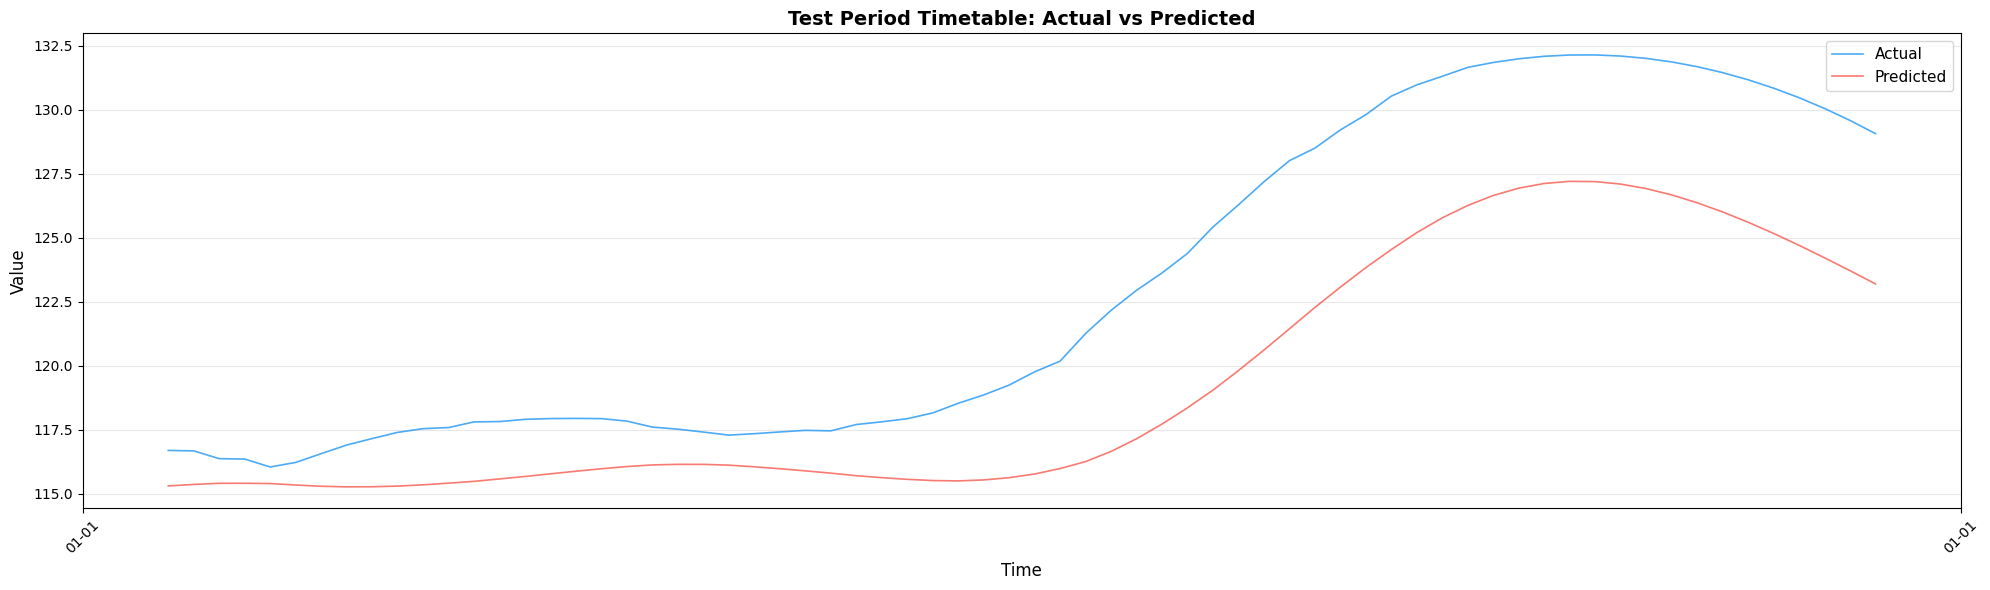

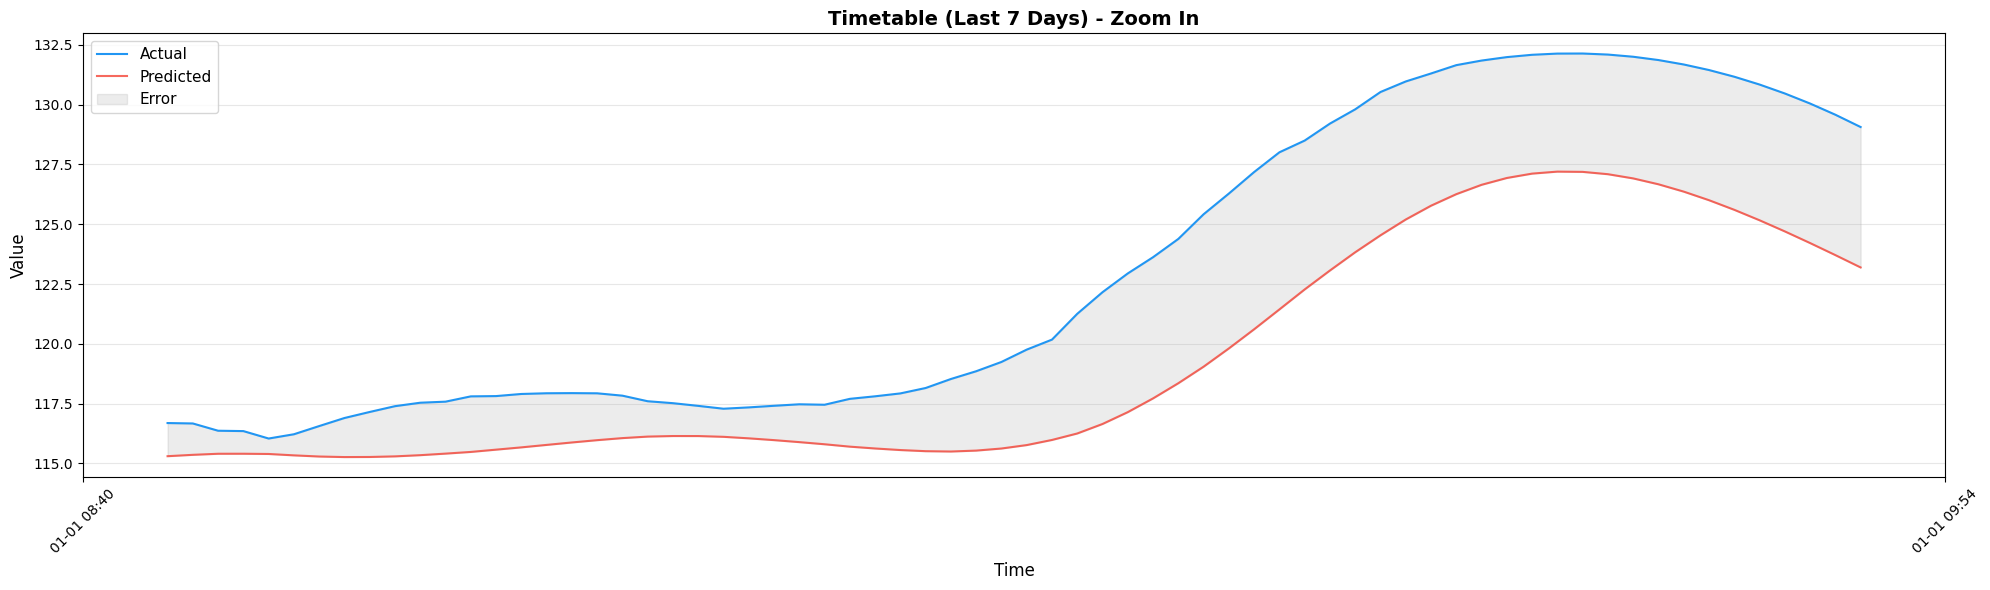

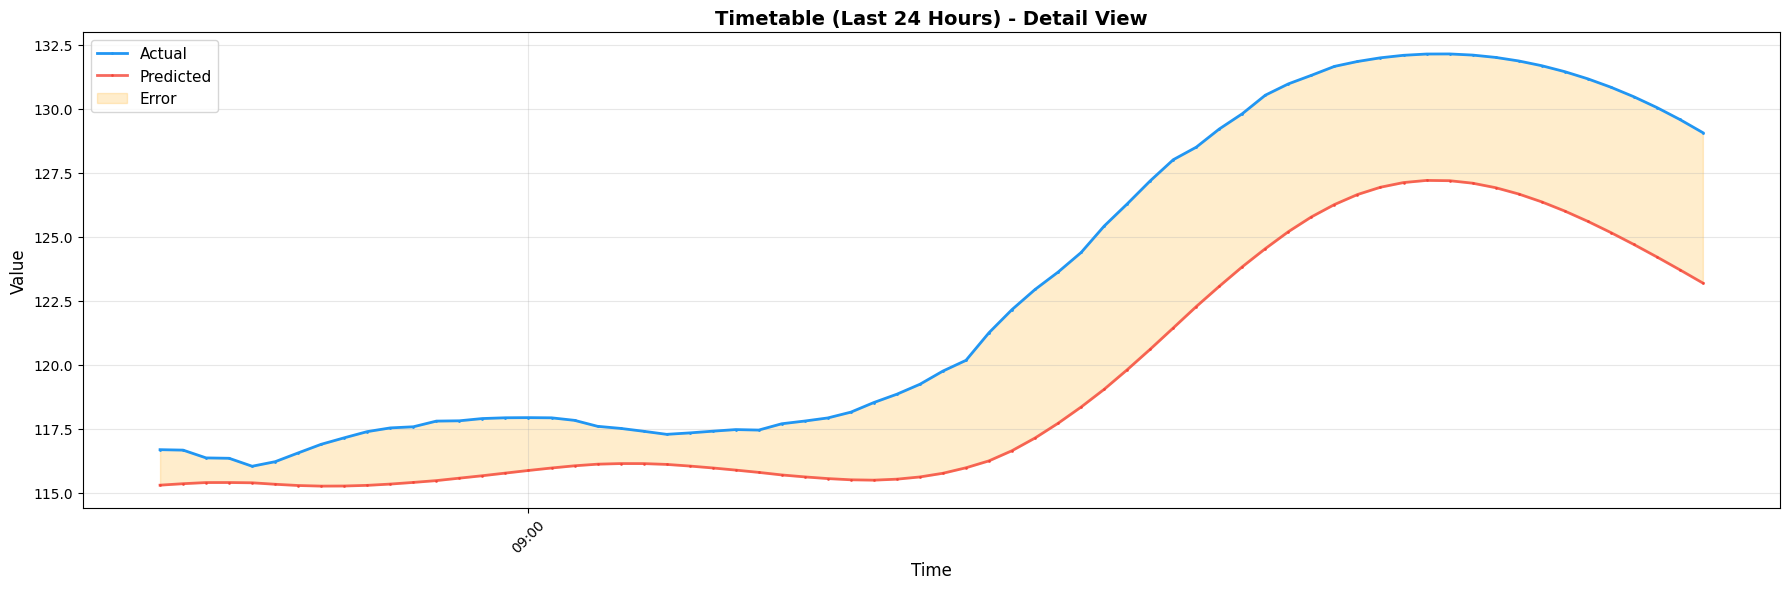


=== Timetable 요약 ===
테스트 기간: 2023-01-01 08:44:00 ~ 2023-01-01 09:51:00
총 샘플 수: 68개
RMSE: 8.9581, MAE: 8.0344, MAPE: 6.41%


In [37]:
import matplotlib.dates as mdates

# 테스트 구간의 시간 인덱스 복원 (numpy datetime64로 명시 변환)
test_start = val_idx + input_time
test_times = pd.to_datetime(df_filtered['time'].iloc[test_start : test_start + len(test_actual_original)]).to_numpy()

# 실제값: 각 샘플의 첫 번째 예측값으로 연속 시계열 구성
actual_series = test_actual_original[:, 0]
pred_series = test_pred_original[:, 0]

# === 1. 전체 테스트 구간 Timetable ===
fig, ax = plt.subplots(figsize=(20, 6))

ax.plot(test_times, actual_series, label='Actual', linewidth=1.2, color='#2196F3', alpha=0.8)
ax.plot(test_times, pred_series, label='Predicted', linewidth=1.2, color='#F44336', alpha=0.7)

ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Value', fontsize=12)
ax.set_title('Test Period Timetable: Actual vs Predicted', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# === 2. 1주일 단위 확대 Timetable (마지막 7일) ===
samples_per_day = 60 * 24  # 1분 간격 = 1440 samples/day
last_7days = 7 * samples_per_day

fig, ax = plt.subplots(figsize=(20, 6))

times_zoom = test_times[-last_7days:]
actual_zoom = actual_series[-last_7days:]
pred_zoom = pred_series[-last_7days:]

ax.plot(times_zoom, actual_zoom, label='Actual', linewidth=1.5, color='#2196F3')
ax.plot(times_zoom, pred_zoom, label='Predicted', linewidth=1.5, color='#F44336', alpha=0.8)
ax.fill_between(times_zoom, actual_zoom, pred_zoom, alpha=0.15, color='gray', label='Error')

ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Value', fontsize=12)
ax.set_title('Timetable (Last 7 Days) - Zoom In', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# === 3. 1일 단위 확대 Timetable (마지막 24시간) ===
last_1day = samples_per_day

fig, ax = plt.subplots(figsize=(18, 6))

times_1d = test_times[-last_1day:]
actual_1d = actual_series[-last_1day:]
pred_1d = pred_series[-last_1day:]

ax.plot(times_1d, actual_1d, label='Actual', linewidth=2, marker='.', markersize=2, color='#2196F3')
ax.plot(times_1d, pred_1d, label='Predicted', linewidth=2, marker='.', markersize=2, color='#F44336', alpha=0.8)
ax.fill_between(times_1d, actual_1d, pred_1d, alpha=0.2, color='orange', label='Error')

ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Value', fontsize=12)
ax.set_title('Timetable (Last 24 Hours) - Detail View', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

print(f"\n=== Timetable 요약 ===")
print(f"테스트 기간: {pd.Timestamp(test_times[0])} ~ {pd.Timestamp(test_times[-1])}")
print(f"총 샘플 수: {len(test_times):,}개")
print(f"RMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}, MAPE: {test_mape:.2f}%")